# 데이터분석프로그래밍 11주차 실습

## 실습 시작 전 유의사항

※ 상단 메뉴에서 '**파일 - 드라이브에 사본 저장**' 진행 후 시작하세요.\
※ 프로젝트 제목 뒤에 본인의 이름과 학번을 작성하세요. `ex) DataAnalysisProgramming_#01_202312345_정재호.ipynb`

## 실습 개요
- 데이터 전처리
  - 이상치 처리
  - 누락 데이터 처리
  - 불균형 데이터 처리

---

## 이상치 처리

통계적으로 많이 벗어나있는 이상치는 통계 분석이나 모델 학습에 좋지 않은 영향을 줍니다.

이번 실습에서는 이상치를 찾는 방법 중 IQR을 사용해봅시다.

In [ ]:
import pandas as pd
import numpy as np

# 와인 품질 데이터셋 불러오기
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_df = pd.read_csv(url, delimiter=";")   # 세미콜론으로 구분된 데이터셋에 대한 처리

wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


이 데이터 중 pH 변수에 대해서 이상치를 찾아보고자 합니다.

boxplot은 이상치를 찾을 때 많이 사용하는 시각화 방법입니다.

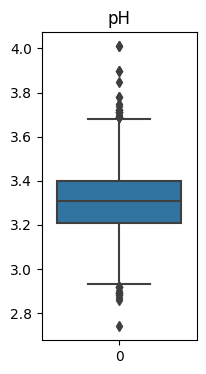

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

attribute = 'pH'

fig = plt.figure(figsize=(2, 4))

# 보고자 하는 변수의 데이터를 매개변수로 넣는다.
sns.boxplot(wine_df[attribute])
plt.title(attribute)

plt.show()

boxplot은 IQR를 바탕으로 그려지는 차트입니다.

이 차트가 의미하는 것이 무엇인지 IQR을 직접 구현하여 알아보도록 합시다.

<img src="https://media.licdn.com/dms/image/C5612AQHmj-jx1e72iA/article-inline_image-shrink_400_744/0/1592543224278?e=1705536000&v=beta&t=S6HwwyObU14dSMobOS5KOTh7lXiP3c5AagKnVeJ67vY" width="70%">

Q1과 Q3은 데이터의 하위 25%와 상위 25%를 의미합니다.

IQR은 Q1부터 Q3까지의 범위로, 데이터셋의 중간 50%입니다.
이를 통해 중앙값 근처의 분포를 확인할 수 있습니다.

여기서 Q1보다 1.5\*IQR 만큼 낮거나, Q3보다 1.5\*IQR만큼 높은 것을 이상치로 구분합니다.

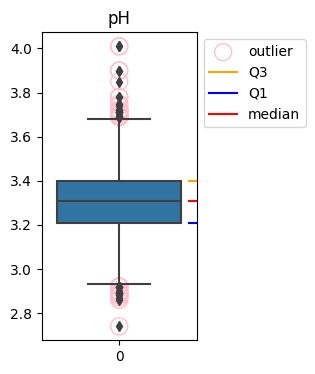

In [ ]:
# 이상치 찾기
## quantile 메소드를 통해 하위 x 만큼의 값을 얻는다.
Q1 = wine_df[attribute].quantile(0.25)
Q3 = wine_df[attribute].quantile(0.75)

## Q3에서 Q1을 뺀 만큼이 IQR (중앙 50% 범위의 크기)
IQR = Q3 - Q1

## Q1 - 1.5*IQR보다 작거나, Q3 + 1.5*IQR보다 크면 이상치
outlier_mask = (wine_df[attribute] < Q1-1.5*IQR) | (wine_df[attribute] > Q3+1.5*IQR)
outlier = wine_df[outlier_mask]

# 이상치 시각화
import numpy as np
fig = plt.figure(figsize=(2, 4))

sns.boxplot(wine_df[attribute])
plt.scatter(np.zeros_like(outlier[attribute]), outlier[attribute], s=150,  edgecolor='pink', facecolors='none', label='outlier')  # outlier
plt.axhline(Q3, xmin=0.95, color='orange', label='Q3')   # Q3
plt.axhline(Q1, xmin=0.95, color='blue', label='Q1')   # Q1
plt.axhline(wine_df[attribute].median(), xmin=0.95, color='red', label='median')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title(attribute)

plt.show()

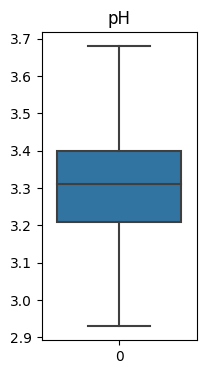

In [ ]:
cleaned_df = wine_df[~outlier_mask]  # 이상치를 제거한 데이터프레임

#cleaned_df = wine_df.drop(outlier.index, axis=0)

fig = plt.figure(figsize=(2, 4))

sns.boxplot(cleaned_df[attribute])
plt.title(attribute)

plt.show()

## 누락 데이터 처리

예전 실습 때는 이상치를 처리하는 방법으로 pandas의 fillna 메소드를 사용했습니다.

sklearn에서도 이와 같이 누락 데이터를 특정 값으로 채워주는 도구를 제공하는데,\
그것을 직접 사용해보고 이렇게 통계값으로 채우는 행위가 어떤 문제를 일으키는지 확인해봅시다.

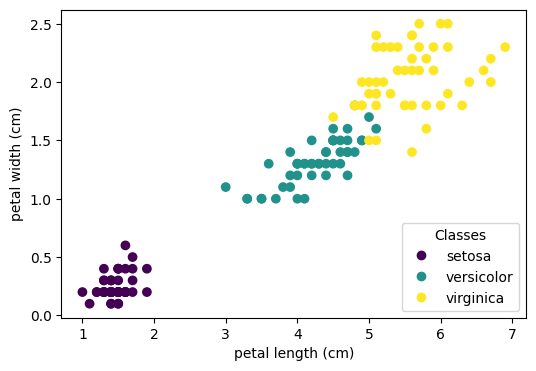

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt

# 데이터셋 준비
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# 꽃잎(petal) 크기에 대해 데이터셋 시각화
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set(xlabel='petal length (cm)', ylabel='petal width (cm)')
ax.legend(scatter.legend_elements()[0], iris.target_names, loc='lower right', title='Classes')
plt.show()

결측치를 단순히 mean이나 median 같은 통계값으로 채우는 것을 Simple Imputation이라고 말합니다.

이런 작업을 sklearn의 SimpleImputer로 수행할 수 있습니다.

SimpleImputer 객체를 만들고 데이터를 학습시켜 결측치를 채워봅시다.

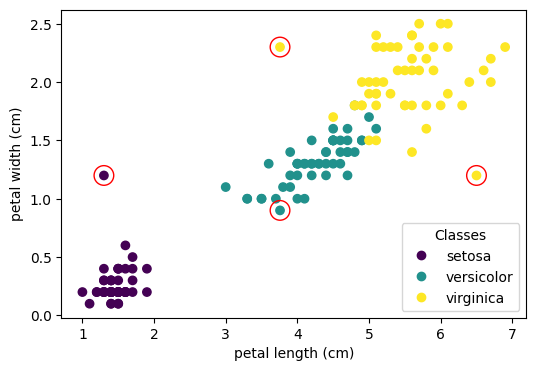

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

# SimpleImputer 객체를 만들기. 채우는 전략(strategy)를 매개변수로 줘야 한다.
imp_mean = SimpleImputer(strategy = 'mean')

# 기준으로 하는 데이터셋을 제공하여 학습시키기 (fit 메소드)
imp_mean.fit(X)

# 결측치 데이터
new_X = np.array([[np.nan, 2.3], [6.5, np.nan], [1.3, np.nan], [np.nan, 0.9]])
new_y = np.array([2, 2, 0, 1])

# 데이터의 결측치를 채우기 (transform 메소드)
filled_X = imp_mean.transform(new_X)

# 결측치를 채운 데이터셋 시각화 (SimpleImputer)
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
scatter_new = ax.scatter(filled_X[:, 0], filled_X[:, 1], c=new_y)
scatter_new = ax.scatter(filled_X[:, 0], filled_X[:, 1], edgecolor='red', facecolors='none', s=200)
ax.set(xlabel='petal length (cm)', ylabel='petal width (cm)')
ax.legend(scatter.legend_elements()[0], iris.target_names, loc='lower right', title='Classes')
plt.show()

위에서 본 것처럼 단순 통계값으로 채우는 행위는 구현이 간단하고 성능이 빠를 수는 있지만,\
다른 변수와의 관계를 고려하지 않는 좋지 않은 방법입니다.

그래서 sklearn에서는 유사한 이웃 데이터를 바탕으로 결측값을 추정해주는 KNNImputer를 제공합니다.



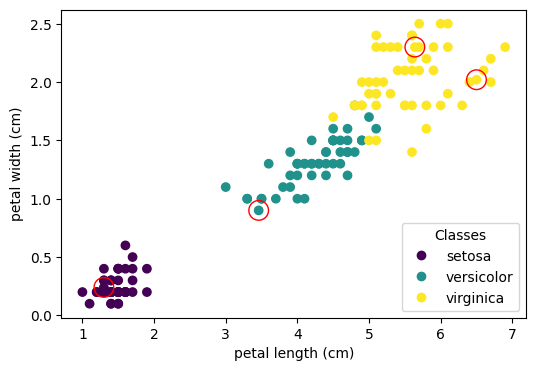

In [ ]:
from sklearn.impute import KNNImputer

# KNNImputer 객체 생성. 몇 개의 이웃을 참고할지(n_neighbors)를 매개변수로 줘야한다.
imputer = KNNImputer(n_neighbors=5)

# 학습
imputer.fit(X)

# 추정
knn_X = imputer.transform(new_X)

# 결측치를 채운 데이터셋 시각화 (KNNImputer)
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
scatter_new = ax.scatter(knn_X[:, 0], knn_X[:, 1], c=new_y)
scatter_new = ax.scatter(knn_X[:, 0], knn_X[:, 1], edgecolor='red', facecolors='none', s=200)
ax.set(xlabel='petal length (cm)', ylabel='petal width (cm)')
ax.legend(scatter.legend_elements()[0], iris.target_names, loc='lower right', title='Classes')
plt.show()

위에서 실습한 예제에는 기준 데이터 X와 결측치 데이터 new_X가 분리돼 있습니다.

만약 사용하고자 하는 데이터셋 내부에 결측치가 포함돼있다면\
fit과 transform을 분리할 필요 없이 fit_transform으로 한 번에 수행할 수 있습니다.

In [ ]:
data = pd.DataFrame(np.concatenate((X, new_X)), columns=iris.feature_names[2:4])
print("결측치가 있는 데이터셋")
print(data.tail())

filled_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
print("\n결측치를 채운 데이터셋")
print(filled_data.tail())

결측치가 있는 데이터셋
     petal length (cm)  petal width (cm)
149                5.1               1.8
150                NaN               2.3
151                6.5               NaN
152                1.3               NaN
153                NaN               0.9

결측치를 채운 데이터셋
     petal length (cm)  petal width (cm)
149           5.100000          1.800000
150           5.966667          2.300000
151           6.500000          2.033333
152           1.300000          0.266667
153           3.433333          0.900000


## 불균형 데이터 처리

한 쪽으로 치우쳐져 있는 데이터셋은 이상치와 비슷한 이유로 통계 분석과 모델 학습에 좋지 않은 영향을 줍니다.

대표적인 예시로는, 개와 고양이를 분류하는 문제에서 만약 고양이 데이터가 훨씬 많다면\
단순히 모든 것을 고양이로 예측하는 모델이 좋은 성능을 낸다고 평가될 수 있습니다.

그렇기에 개수를 최대한 서로 맞춰주는 것이 중요합니다.


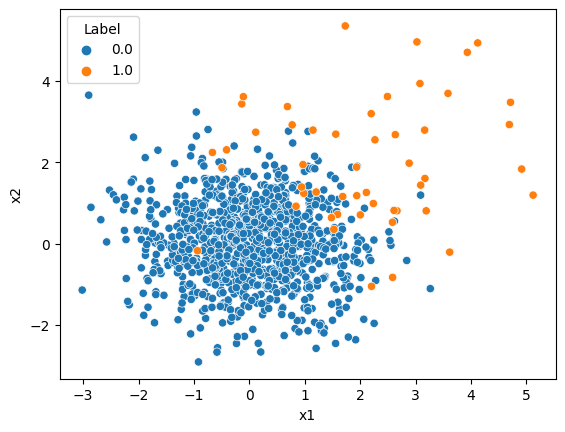

0.0    1000
1.0      50
Name: Label, dtype: int64


In [ ]:
import numpy as np
import pandas as pd

# 클래스별 샘플 수 설정
n_samples_class1 = 1000  # 다수 클래스
n_samples_class2 = 50   # 소수 클래스

# 임의의 데이터 생성
# 클래스 1: 평균 0, 표준편차 1
data_class1 = np.random.normal(0, 1, (n_samples_class1, 2))
labels_class1 = np.zeros(n_samples_class1)

# 클래스 2: 평균 2, 표준편차 1.5
data_class2 = np.random.normal(2, 1.5, (n_samples_class2, 2))
labels_class2 = np.ones(n_samples_class2)

# 데이터셋 결합
data_combined = np.vstack((data_class1, data_class2))
labels_combined = np.hstack((labels_class1, labels_class2))

# Pandas DataFrame으로 변환
df = pd.DataFrame(data_combined, columns=['x1', 'x2'])
df['Label'] = labels_combined

fig = plt.figure()
sns.scatterplot(data=df, x='x1', y='x2', hue='Label')
plt.show()

print(df['Label'].value_counts())

대표적인 불균형 데이터 처리 방법인 SMOTE를 실습해 봅시다.

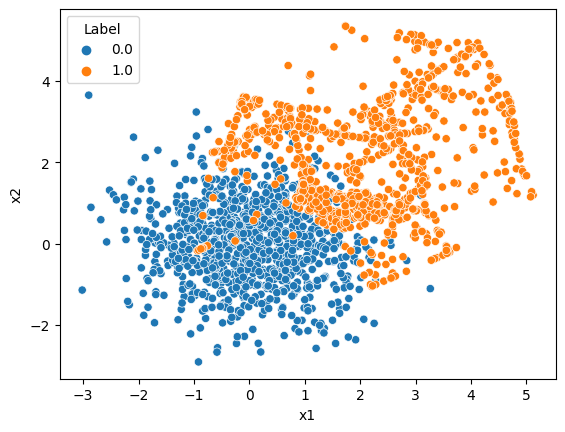

0.0    1000
1.0    1000
Name: Label, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성. 몇 개의 이웃을 참고할지(k_neighbors)를 매개변수로 줘야한다.
smote = SMOTE(k_neighbors=10)

# X와 y를 제공해서 새로운 X, y 생성 (fit_resample 메소드)
X_sm, y_sm = smote.fit_resample(df.drop(columns='Label'), df['Label'])   # X: df.drop(columns='Label'), y: df['Label']

data_sm = pd.DataFrame(X_sm, columns=['x1', 'x2'])
data_sm['Label'] = y_sm

# 증가된 데이터셋 시각화
fig = plt.figure()
sns.scatterplot(data=data_sm, x='x1', y='x2', hue='Label')
plt.show()

print(data_sm['Label'].value_counts())

## 실습 종료 전 유의사항

※ 완료 시 우측 상단 프로필 옆 '**공유 - 액세스를 *링크가 있는 모든 사용자*로 전환**' 후 복사한 링크를 이루리 과제 란에 업로드 하세요.

<img src="https://drive.google.com/uc?id=1Zj1FKIz0sanqUfkfr3scp5M-dDgMFxYQ" height=300>

</br>

※ 추가로 상단 메뉴 '**파일 - 다운로드 - .ipynb**' 로 다운로드 후 첨부 파일로 업로드 하세요.

※ 즉, 과제의 텍스트란에는 링크를, 파일 첨부란에는 .ipynb 파일을 제출하십시오.